In [42]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
import operator
from dotenv import load_dotenv
import os
from euriai.langchain import create_chat_model
from langgraph.checkpoint.memory import InMemorySaver
import time

load_dotenv()
api_key = os.getenv("key")

In [43]:
chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

print("Chat model created successfully.")

Chat model created successfully.


In [51]:
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [52]:
def step_1(state: CrashState):
    print("Executing Step 1: Analyzing the input.")
    return {"step1": f"done"}

def step_2(state: CrashState):
    print("Executing Step 2: Processing the data after hanging the code for 30 seconds.")
    time.sleep(30)
    return {"step2": f"done"}

def step_3(state: CrashState):
    print("Executing Step 3: Finalizing the results.")
    return {"step3": f"done"}

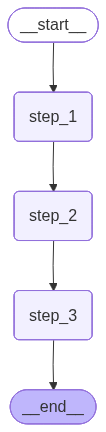

In [53]:
graph = StateGraph(CrashState)

graph.add_node("step_1", step_1)
graph.add_node("step_2", step_2)
graph.add_node("step_3", step_3)

graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)

checkpoint_saver = InMemorySaver()

# Compile with checkpointer
workflow = graph.compile(checkpointer=checkpoint_saver)

# Visualize the workflow
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

### 🛑 How to Interrupt Cell Execution (Without Restarting Kernel)

#### Steps:
1. **Run the next cell** - It will execute and pause for 30 seconds at step_2
2. **Click the Stop button (⏹️)** in the notebook toolbar during the wait
3. **OR use keyboard shortcut**: 
   - VS Code: Click the stop icon next to the running cell
   - Jupyter: Press `Ctrl+C` or click Interrupt kernel button
4. The `KeyboardInterrupt` exception will be caught
5. **Kernel stays running** - no restart needed!

#### What Happens:
- ✅ Execution stops at the current step
- ✅ **Checkpoint is saved** at the last completed node
- ✅ Kernel remains active
- ✅ You can inspect the state
- ✅ You can resume from where it stopped

#### Try It:
1. Run the cell below
2. Wait for "Executing Step 2" message
3. Click the stop button
4. Run the following cells to check state and resume

In [54]:
try:
    print("⏳ Starting workflow execution...")
    print("💡 TIP: Click the Stop button (⏹️) during the 30-second wait to interrupt!\n")
    
    config1 = {"configurable": {"thread_id": "abhi123"}}
    result = workflow.invoke({"input": "start"}, config=config1)
    
    print("\n✅ Workflow completed successfully!")
    print(f"Final result: {result}")
    
except KeyboardInterrupt:
    print("\n🛑 Execution interrupted! (Kernel still running)")
    print("📊 Let's check where the workflow stopped...")

⏳ Starting workflow execution...
💡 TIP: Click the Stop button (⏹️) during the 30-second wait to interrupt!

Executing Step 1: Analyzing the input.
Executing Step 2: Processing the data after hanging the code for 30 seconds.

🛑 Execution interrupted! (Kernel still running)
📊 Let's check where the workflow stopped...


In [55]:
# Check the state after interruption
config1 = {"configurable": {"thread_id": "abhi123"}}
current_state = workflow.get_state(config=config1)

print("📍 Current State After Interruption:")
print("================================")
print(current_state)
print(f"Next node to execute: {current_state.next}")
print(f"\nState values:")
for key, value in current_state.values.items():
    print(f"  {key}: {value}")

print("\n💾 This is where the workflow was saved (checkpointed)!")
print("🔄 You can resume from here without restarting the kernel.")

📍 Current State After Interruption:
StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe23-7396-65db-8001-e124e8c4ee0d'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-22T11:32:48.872991+00:00', parent_config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe23-7394-610e-8000-19787ded314e'}}, tasks=(PregelTask(id='c4af3077-a1dc-27dc-bdc6-63547126d2df', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())
Next node to execute: ('step_2',)

State values:
  input: start
  step1: done

💾 This is where the workflow was saved (checkpointed)!
🔄 You can resume from here without restarting the kernel.


In [56]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe23-7396-65db-8001-e124e8c4ee0d'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-22T11:32:48.872991+00:00', parent_config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe23-7394-610e-8000-19787ded314e'}}, tasks=(PregelTask(id='c4af3077-a1dc-27dc-bdc6-63547126d2df', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe23-7394-610e-8000-19787ded314e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-22T11:32:48.872052+00:00', parent_config={'configurable': {'thread_id': 'abhi123', 'checkpoint_ns': '', 'checkp

In [57]:
# Resume the workflow from where it stopped
print("🔄 Resuming workflow from the checkpoint...\n")

config1 = {"configurable": {"thread_id": "abhi123"}}

# Invoke with None to resume from checkpoint
result = workflow.invoke(None, config=config1)

print("\n✅ Workflow resumed and completed successfully!")
print("Final result:", result)

🔄 Resuming workflow from the checkpoint...

Executing Step 2: Processing the data after hanging the code for 30 seconds.
Executing Step 3: Finalizing the results.

✅ Workflow resumed and completed successfully!
Final result: {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}
